In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [258]:
PROCESSED_DIR = Path("data/processed")

api_path    = PROCESSED_DIR / "api_clean.csv"
mercer_path = PROCESSED_DIR / "mercer_clean.csv"

api_clean    = pd.read_csv(api_path)
mercer_clean = pd.read_csv(mercer_path)

print("API shape:", api_clean.shape)
print("Mercer shape:", mercer_clean.shape)

print("\nAPI columns:\n", api_clean.columns.tolist())
print("\nMercer columns:\n", mercer_clean.columns.tolist())

API shape: (138, 9)
Mercer shape: (71, 7)

API columns:
 ['location_clean', 'job_title_clean', 'job_level_clean', 'min_salary_annual_gbp', 'max_salary_annual_gbp', 'avg_salary_annual_gbp', 'confidence', 'publisher_name', 'source_file']

Mercer columns:
 ['location_clean', 'job_title_clean', 'job_level_clean', 'p25_GBP', 'p50_GBP', 'p75_GBP', 'mkt_base_avg_GBP']


In [259]:
mercer_clean["location_final"] = mercer_clean["location_clean"].replace({
    "Lisbon": "Portugal",
    "Malmö": "Sweden",
    "Malmo": "Sweden",
})

mercer_clean["location_final"] = mercer_clean["location_final"].fillna(mercer_clean["location_clean"])

In [260]:
mercer_for_merge = mercer_clean.rename(columns={
    "location_final": "location", 
    "job_title_clean": "job_title",
    "job_level_clean": "job_level",
    "mkt_base_avg_GBP": "salary_gbp"
}).copy()

mercer_for_merge["source"] = "Mercer"


In [261]:
api_for_merge = api_clean.rename(columns={
    "location_clean": "location",
    "job_title_clean": "job_title",
    "avg_salary_annual_gbp": "salary_gbp",
}).copy()

In [262]:
def map_api_to_mercer_bucket(title):
    if pd.isna(title):
        return None
    t = str(title).lower()

    if any(k in t for k in [
        "backend engineer", "frontend engineer", "software developer",
        "software engineer", "full stack", "full-stack", "web developer",
        "application developer"
    ]):
        return "Full Stack Engineer"

    if any(k in t for k in [
        "ios", "android", "mobile", "mobile application", "app developer"
    ]):
        return "Mobile Engineer"

    if any(k in t for k in [
        "ux", "product designer", "interaction designer",
        "visual designer", "ux researcher", "designer"
    ]):
        return "UX Designer"

    if any(k in t for k in [
        "qa", "quality assurance", "test engineer", "software tester",
        "quality analyst", "automation engineer", "sdet"
    ]):
        return "QA Engineer"

    return str(title).title()

api_clean["role_bucket"] = api_clean["job_title_clean"].apply(map_api_to_mercer_bucket)

api_clean = api_clean.dropna(subset=["role_bucket"])

In [263]:
if "job_level" not in api_for_merge.columns:
    if "level_name" in api_for_merge.columns:
        api_for_merge["job_level"] = api_for_merge["level_name"]
    elif "job_level_clean" in api_for_merge.columns:
        api_for_merge["job_level"] = api_for_merge["job_level_clean"]
    else:
        api_for_merge["job_level"] = pd.NA

api_for_merge["source"] = "API"

cols_keep = ["location", "job_title", "job_level", "salary_gbp", "source"]
mercer_for_merge = mercer_for_merge[cols_keep]
api_for_merge    = api_for_merge[cols_keep]

combined_clean = pd.concat([mercer_for_merge, api_for_merge], ignore_index=True)

print("\nCombined shape:", combined_clean.shape)
combined_clean.head(10)


Combined shape: (209, 5)


,location,job_title,job_level,salary_gbp,source
0,London,Mobile Engineer,Senior,74047.589733,Mercer
1,London,Mobile Engineer,Lead,88886.633500,Mercer
2,London,UX Designer,Junior,46345.471867,Mercer
3,London,UX Designer,Mid,48619.050833,Mercer
4,London,UX Designer,Senior,72060.283367,Mercer
5,London,UX Designer,Lead,89297.052700,Mercer
6,London,UX Designer,Principal,102249.668700,Mercer
7,London,UX Designer,Head of,123141.600733,Mercer
8,London,Full Stack Engineer,Junior,47095.345900,Mercer
9,London,Full Stack Engineer,Mid,70175.972367,Mercer


In [264]:
merc = mercer_clean.copy()

merc = merc.rename(columns={
    "p25_GBP": "p25",
    "p50_GBP": "p50",
    "p75_GBP": "p75",
    "location_clean": "location",
    "job_title_clean": "job_title",
    "job_level_clean": "job_level"
})

bands = merc[["location","job_title","job_level","p25","p50","p75"]].dropna()

In [265]:
level_col = next(
    c for c in ["job_level", "job_level_clean", "level_name", "level"]
    if c in api_clean.columns
)

api_mean = (
    api_clean
      .groupby(["location_clean", "job_title_clean", level_col], as_index=False)
      ["avg_salary_annual_gbp"].mean()
      .rename(columns={
          "location_clean": "location",
          "job_title_clean": "job_title",
          level_col: "job_level",
          "avg_salary_annual_gbp": "api_mean"
      })
)

bands_vs_api = bands.merge(api_mean, on=["location","job_title","job_level"], how="left")
bands_vs_api["api_gap_%"] = (bands_vs_api["api_mean"] - bands_vs_api["p50"]) / bands_vs_api["p50"] * 100

bands_vs_api.sort_values(["location","job_title","job_level"]).head(20)

,location,job_title,job_level,p25,p50,p75,api_mean,api_gap_%
52,Lisbon,Full Stack Engineer,Head of,88474.264160,104836.619150,116475.878420,NaN,NaN
40,Lisbon,Full Stack Engineer,Lead,44352.215960,49299.110985,54075.487595,NaN,NaN
50,Lisbon,Full Stack Engineer,Lead,42979.540760,47948.471015,55873.403005,NaN,NaN
38,Lisbon,Full Stack Engineer,Mid,32987.890805,35439.153105,40216.693790,NaN,NaN
48,Lisbon,Full Stack Engineer,Mid,22737.409135,25563.555265,36122.687320,NaN,NaN
51,Lisbon,Full Stack Engineer,Principal,54651.081755,60736.300775,67718.827650,NaN,NaN
39,Lisbon,Full Stack Engineer,Senior,39584.274325,46322.699560,51489.132415,NaN,NaN
49,Lisbon,Full Stack Engineer,Senior,32832.219680,40778.102385,51501.623675,NaN,NaN
44,Lisbon,Mobile Engineer,Senior,36885.906230,42856.886270,52128.545680,NaN,NaN
53,Lisbon,QA Engineer,Junior,22787.833260,24777.694310,27784.056590,NaN,NaN


In [266]:
def rec_range(row):
    return f"£{row.p50:,.0f}–£{row.p75:,.0f}"

bands["recommended_offer"] = bands.apply(rec_range, axis=1)

In [267]:
print("\nCounts by source:")
display(combined_clean["source"].value_counts())

print("\nCounts by location (overall):")
display(combined_clean["location"].value_counts(dropna=False))

print("\nCounts by location & source:")
display(combined_clean.groupby(["location","source"]).size().unstack(fill_value=0))

print("\nCounts by job_title & source:")
display(combined_clean.groupby(["job_title","source"]).size().unstack(fill_value=0))


Counts by source:


source
API       138
Mercer     71
Name: count, dtype: int64


Counts by location (overall):


location
Portugal    69
New York    62
Sweden      56
London      22
Name: count, dtype: int64


Counts by location & source:


source,API,Mercer
location,,
London,0,22
New York,48,14
Portugal,48,21
Sweden,42,14



Counts by job_title & source:


source,API,Mercer
job_title,,
Backend Engineer,18,0
Frontend Engineer,18,0
Full Stack Engineer,18,26
Mobile Engineer,12,3
QA Engineer,18,20
Software Developer,18,0
Software Engineer,18,0
UX Designer,18,22


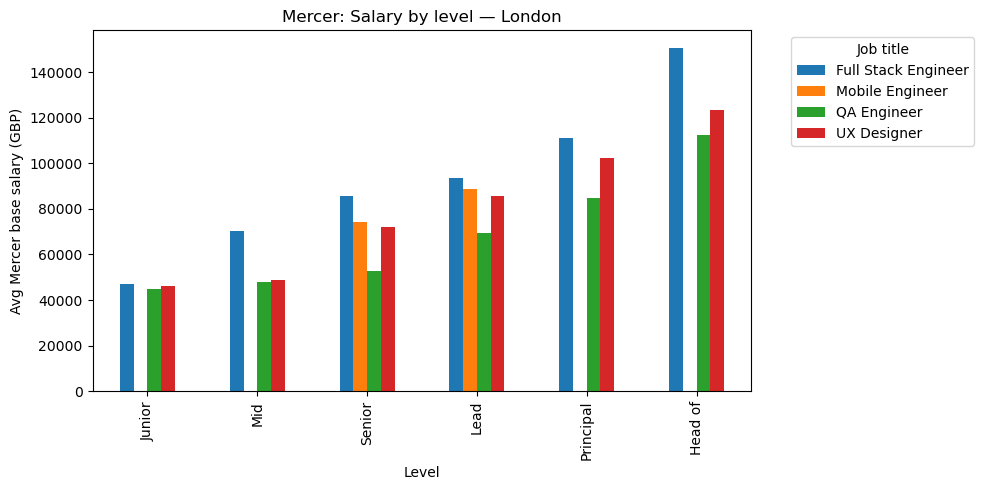

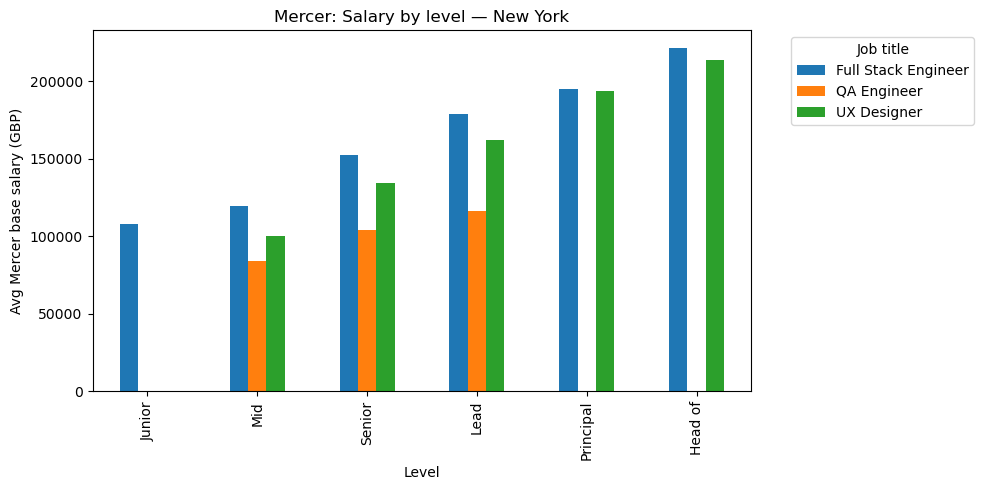

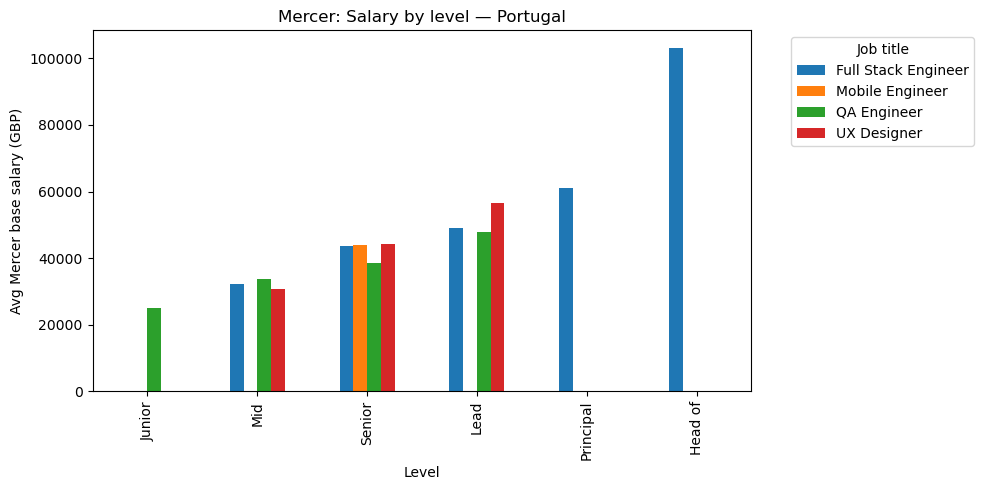

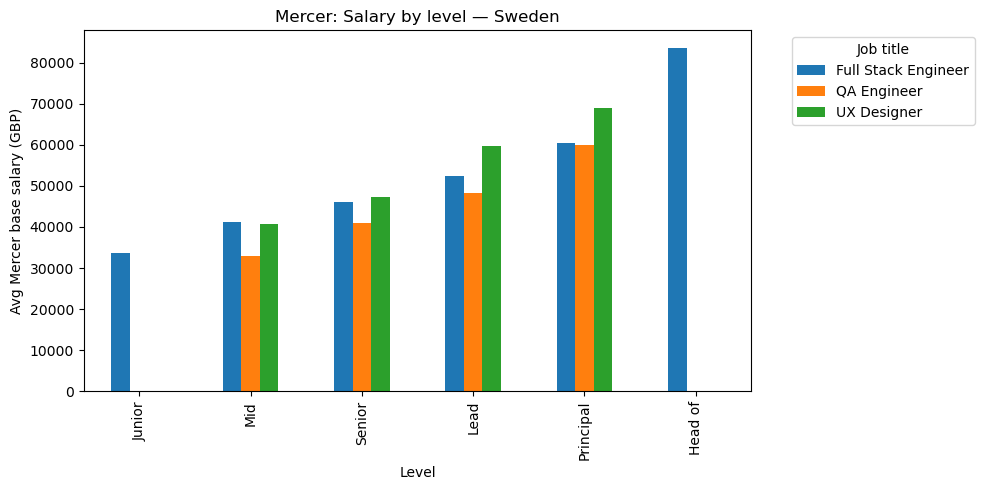

In [268]:
LEVEL_ORDER = ["Junior", "Mid", "Senior", "Lead", "Principal", "Head of"]

mercer_summary = (
    combined_clean[combined_clean.source=="Mercer"]
    .dropna(subset=["salary_gbp"])
    .groupby(["location","job_level","job_title"], as_index=False)["salary_gbp"]
    .mean()
)

for loc in mercer_summary["location"].dropna().unique():
    subset = mercer_summary[mercer_summary["location"] == loc]
    pivot = subset.pivot(index="job_level", columns="job_title", values="salary_gbp")

    pivot = pivot.reindex([lvl for lvl in LEVEL_ORDER if lvl in pivot.index])

    ax = pivot.plot(kind="bar", figsize=(10,5))
    ax.set_title(f"Mercer: Salary by level — {loc}")
    ax.set_ylabel("Avg Mercer base salary (GBP)")
    ax.set_xlabel("Level")
    plt.legend(title="Job title", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [269]:
if "job_level" not in api_clean.columns:
    if "level_name" in api_clean.columns:
        api_clean["job_level"] = api_clean["level_name"]
    elif "job_level_clean" in api_clean.columns:
        api_clean["job_level"] = api_clean["job_level_clean"]
    else:
        raise KeyError(
            "No job level column found. Expected one of: job_level, level_name, job_level_clean"
        )

api_clean["job_level"] = api_clean["job_level"].astype(str).str.title()

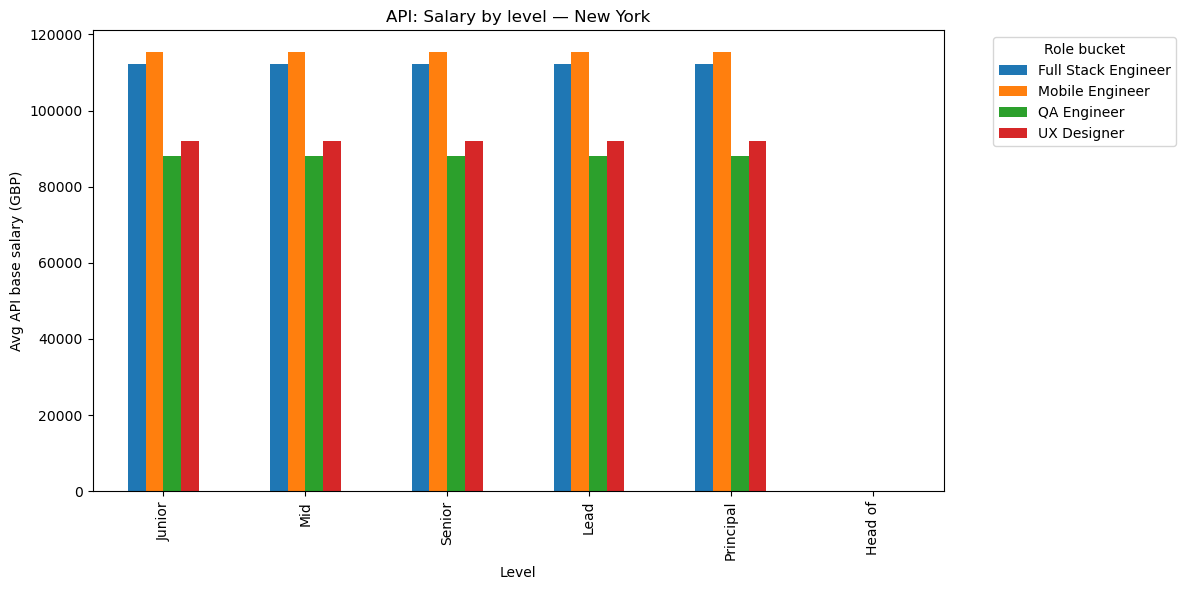

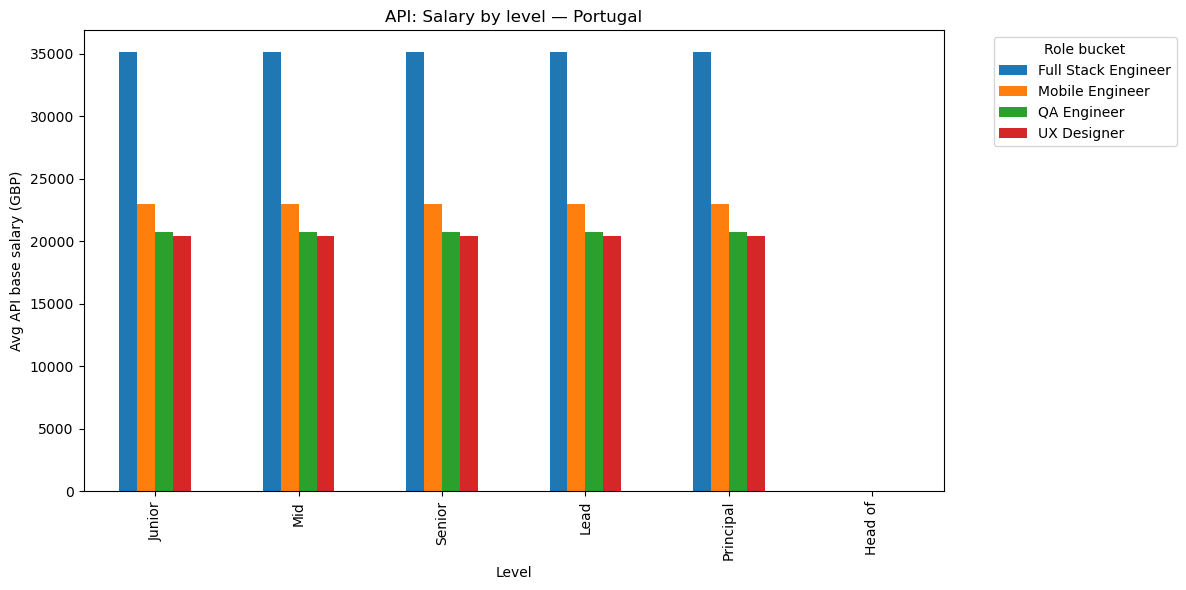

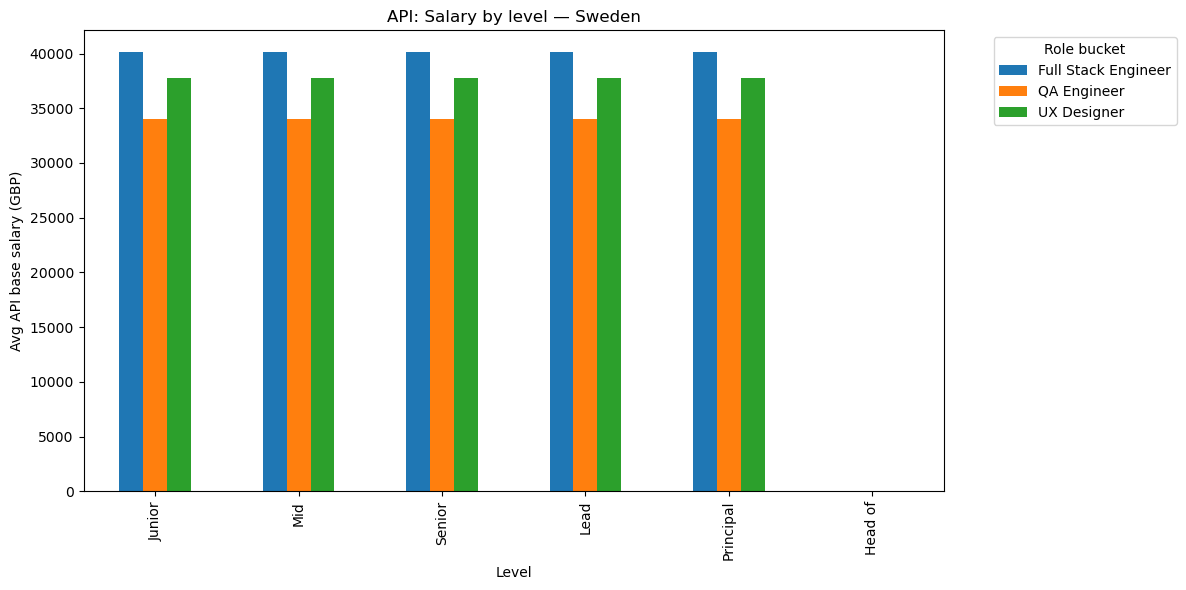

In [270]:
LEVEL_ORDER = ["Junior","Mid","Senior","Lead","Principal","Head of"]

api_summary = (
    api_clean
      .groupby(["location_clean", "job_level", "role_bucket"], as_index=False)["avg_salary_annual_gbp"]
      .mean()
      .rename(columns={
          "location_clean":"location",
          "job_level":"job_level",
          "role_bucket":"job_title",
          "avg_salary_annual_gbp":"salary_gbp"
      })
)

for loc in api_summary["location"].unique():
    subset = api_summary[api_summary["location"] == loc]
    pivot = subset.pivot(index="job_level", columns="job_title", values="salary_gbp")
    pivot = pivot.reindex(LEVEL_ORDER)

    pivot.plot(kind="bar")
    plt.title(f"API: Salary by level — {loc}")
    plt.ylabel("Avg API base salary (GBP)")
    plt.xlabel("Level")
    plt.legend(title="Role bucket", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [271]:
compare_df = (
    combined_clean
    .dropna(subset=["salary_gbp"])
    .groupby(["location","job_title","source"], as_index=False)["salary_gbp"]
    .mean()
)

compare_pivot = compare_df.pivot_table(
    index=["location","job_title"],
    columns="source",
    values="salary_gbp"
)

print("\nAPI vs Mercer pivot (means):")
display(compare_pivot.sort_index())


API vs Mercer pivot (means):


source                                 API         Mercer
location job_title                                       
London   Full Stack Engineer           NaN   93008.001611
         Mobile Engineer               NaN   81467.111617
         QA Engineer                   NaN   68526.323433
         UX Designer                   NaN   76639.193083
New York Backend Engineer     133600.20800            NaN
         Frontend Engineer    123079.56000            NaN
         Full Stack Engineer   79048.26000  162449.396747
         Mobile Engineer      115313.97200            NaN
         QA Engineer           88115.21200  101118.921093
         Software Developer   101656.76400            NaN
         Software Engineer    123836.52400            NaN
         UX Designer           92098.26300  160655.551216
Portugal Backend Engineer      43662.37500            NaN
         Frontend Engineer     41535.14375            NaN
         Full Stack Engineer   29626.75000   51791.526779
         Mobile Engineer       22948.72500   43957.112727
         QA Engineer           20720.23750   37962.500112
         Software Developer    21887.50000            NaN
         Software Engineer     38945.51250            NaN
         UX Designer           20400.00000   46474.072575
Sweden   Backend Engineer      40696.42500            NaN
         Frontend Engineer     38700.00000            NaN
         Full Stack Engineer   37196.31000   52917.336924
         QA Engineer           34030.61250   45563.803163
         Software Developer    40796.77500            NaN
         Software Engineer     43181.25000            NaN
         UX Designer           37782.34500   54195.296243


Overlaps + gaps:


source                               API         Mercer  gap_api_vs_mercer_%
location job_title                                                          
Portugal UX Designer          20400.0000   46474.072575           -56.104557
New York Full Stack Engineer  79048.2600  162449.396747           -51.339764
Portugal Mobile Engineer      22948.7250   43957.112727           -47.792920
         QA Engineer          20720.2375   37962.500112           -45.419197
         Full Stack Engineer  29626.7500   51791.526779           -42.796145
New York UX Designer          92098.2630  160655.551216           -42.673464
Sweden   UX Designer          37782.3450   54195.296243           -30.284826
         Full Stack Engineer  37196.3100   52917.336924           -29.708651
         QA Engineer          34030.6125   45563.803163           -25.312177
New York QA Engineer          88115.2120  101118.921093           -12.859818

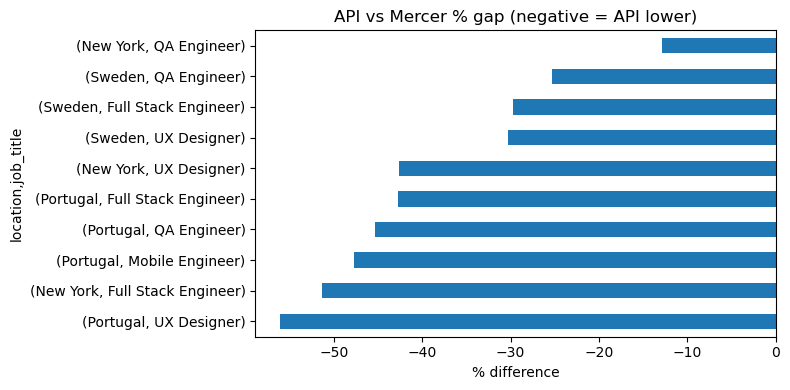

In [272]:
if not {"API","Mercer"}.issubset(compare_pivot.columns):
    print("One of the sources is missing entirely → can't compute gaps.")
else:
    gap_df = compare_pivot.dropna(subset=["API","Mercer"]).copy()

    if gap_df.empty:
        print("No overlaps between API and Mercer yet.")
    else:
        gap_df["gap_api_vs_mercer_%"] = (
            (gap_df["API"] - gap_df["Mercer"]) / gap_df["Mercer"] * 100
        )
        gap_df = gap_df.sort_values("gap_api_vs_mercer_%")

        print("\nOverlaps + gaps:")
        display(gap_df)

        ax = gap_df["gap_api_vs_mercer_%"].plot(kind="barh", figsize=(8,4))
        ax.set_title("API vs Mercer % gap (negative = API lower)")
        ax.set_xlabel("% difference")
        plt.tight_layout()
        plt.show()

In [273]:
print("\nHeadline comparisons (overlaps only):")
if "gap_api_vs_mercer_%" in gap_df.columns:
    print("Mean gap %:", round(gap_df["gap_api_vs_mercer_%"].mean(), 1))
    print("Median gap %:", round(gap_df["gap_api_vs_mercer_%"].median(), 1))
    print("Min gap %:", round(gap_df["gap_api_vs_mercer_%"].min(), 1))
    print("Max gap %:", round(gap_df["gap_api_vs_mercer_%"].max(), 1))


Headline comparisons (overlaps only):
Mean gap %: -38.4
Median gap %: -42.7
Min gap %: -56.1
Max gap %: -12.9


In [274]:
LEVEL_ORDER = ["Junior","Mid","Senior","Lead","Principal","Head of"]
ROLE_ORDER = ["Full Stack Engineer","Mobile Engineer","UX Designer","QA Engineer"]
LOC_ORDER = ["London","Portugal","Sweden","New York"]

def plot_location_heatmaps(
    df,
    value_col="salary_gbp",
    loc_col="location",
    role_col="job_title",
    level_col="job_level",
    title="Salaries — all locations, roles, levels"
):
    d = df[[loc_col, role_col, level_col, value_col]].copy()

    d[loc_col]   = pd.Categorical(d[loc_col], categories=LOC_ORDER, ordered=True)
    d[role_col]  = pd.Categorical(d[role_col], categories=ROLE_ORDER, ordered=True)
    d[level_col] = pd.Categorical(d[level_col], categories=LEVEL_ORDER, ordered=True)

    vmin = d[value_col].min()
    vmax = d[value_col].max()

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), constrained_layout=True)
    axes = axes.ravel()

    for i, loc in enumerate(LOC_ORDER):
        ax = axes[i]
        sub = d[d[loc_col] == loc]

        if sub.empty:
            ax.axis("off")
            ax.text(0.5, 0.5, f"{loc}\nNo data",
                    ha="center", va="center", fontsize=12)
            continue

        pivot = sub.pivot_table(
            index=role_col,
            columns=level_col,
            values=value_col,
            aggfunc="mean"
        ).reindex(index=ROLE_ORDER, columns=LEVEL_ORDER)

        im = ax.imshow(pivot.values, aspect="auto", vmin=vmin, vmax=vmax)
        ax.set_title(loc)

        ax.set_xticks(range(len(LEVEL_ORDER)))
        ax.set_xticklabels(LEVEL_ORDER, rotation=40, ha="right")
        ax.set_yticks(range(len(ROLE_ORDER)))
        ax.set_yticklabels(ROLE_ORDER)

        for r in range(pivot.shape[0]):
            for c in range(pivot.shape[1]):
                val = pivot.iat[r, c]
                if pd.notna(val):
                    ax.text(c, r, f"{val:,.0f}", ha="center", va="center",
        fontsize=8, color="white")


    cbar = fig.colorbar(im, ax=axes, shrink=0.8, label="Avg base salary (GBP)")
    fig.suptitle(title, fontsize=16)
    plt.show()

/var/folders/pl/qjnl2n816kd5trwzkx1r4f9r0000gp/T/ipykernel_90411/63687586.py:35: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(
/var/folders/pl/qjnl2n816kd5trwzkx1r4f9r0000gp/T/ipykernel_90411/63687586.py:35: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(
/var/folders/pl/qjnl2n816kd5trwzkx1r4f9r0000gp/T/ipykernel_90411/63687586.py:35: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(


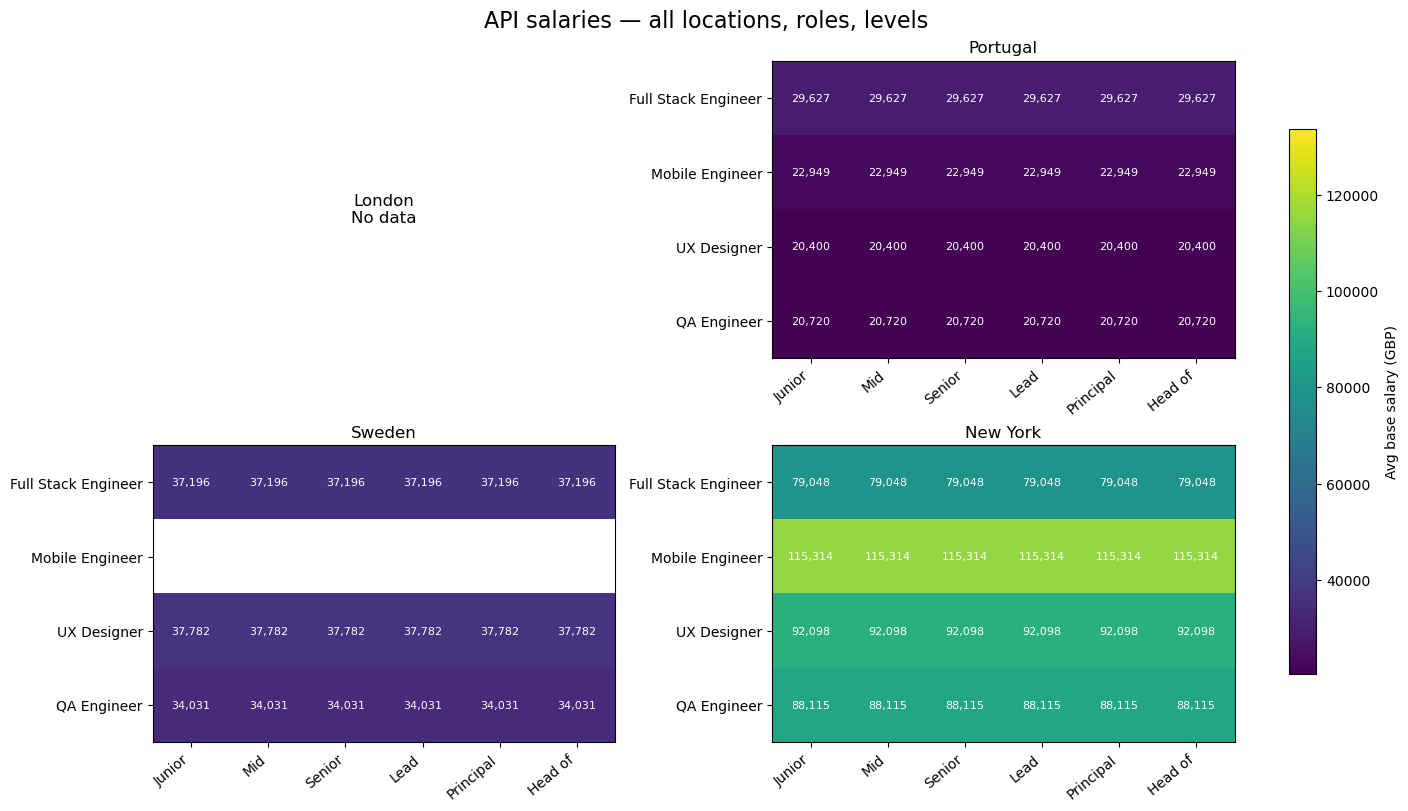

In [275]:
api_only = combined_clean[combined_clean["source"] == "API"]
plot_location_heatmaps(
    api_only,
    value_col="salary_gbp",
    loc_col="location",
    role_col="job_title",
    level_col="job_level",
    title="API salaries — all locations, roles, levels"
)

/var/folders/pl/qjnl2n816kd5trwzkx1r4f9r0000gp/T/ipykernel_90411/63687586.py:35: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(
/var/folders/pl/qjnl2n816kd5trwzkx1r4f9r0000gp/T/ipykernel_90411/63687586.py:35: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(
/var/folders/pl/qjnl2n816kd5trwzkx1r4f9r0000gp/T/ipykernel_90411/63687586.py:35: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(
/var/folders/pl/qjnl2n816kd5trwzkx1r4f9r0000gp/T/ipy

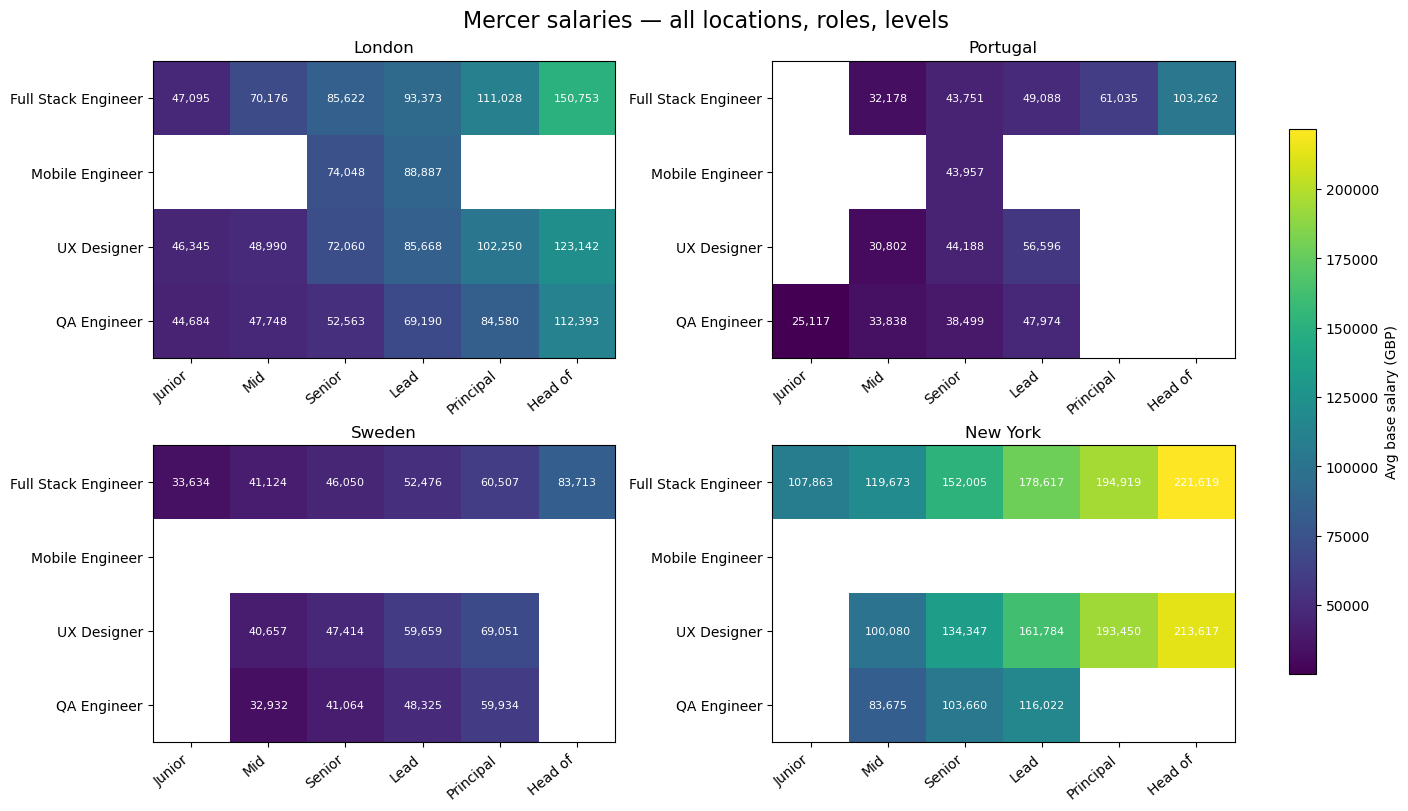

In [276]:
mercer_only = combined_clean[combined_clean["source"] == "Mercer"]
plot_location_heatmaps(
    mercer_only,
    value_col="salary_gbp",
    loc_col="location",
    role_col="job_title",
    level_col="job_level",
    title="Mercer salaries — all locations, roles, levels"
)

[Mercer — role patterns by location] using columns: {'role_col': 'job_title_clean', 'loc_col': 'location_final', 'val_col': 'mkt_base_avg_GBP'}


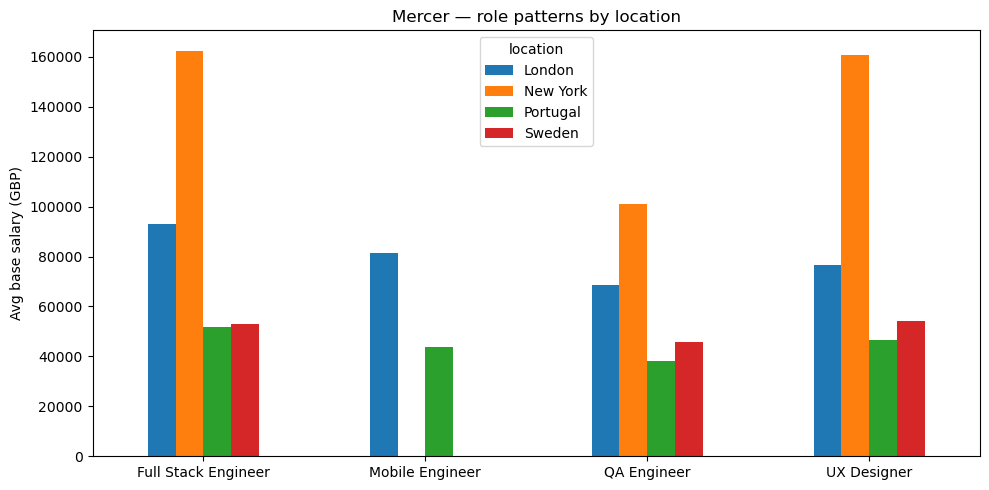

[API — role patterns by location] using columns: {'role_col': 'role_bucket', 'loc_col': 'location_clean', 'val_col': 'avg_salary_annual_gbp'}


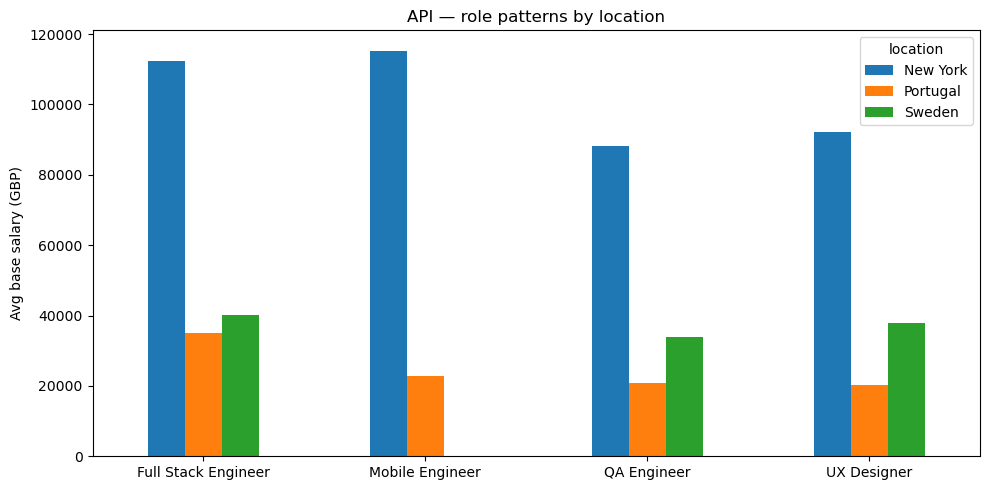

In [277]:
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def plot_role_by_location(df, title):
    role_col = pick_col(df, [
        "role_bucket", "job_title_clean", "job_title", "role"
    ])
    loc_col  = pick_col(df, [
        "location_final", "location_clean", "location", "location_bucket"
    ])
    val_col  = pick_col(df, [
        "salary_gbp", "avg_salary_annual_gbp", "avg_salary_annual_gbp_api",
        "mkt_base_avg_GBP"
    ])

    print(f"[{title}] using columns:",
          {"role_col": role_col, "loc_col": loc_col, "val_col": val_col})

    missing = [k for k,v in {"role_col":role_col,"loc_col":loc_col,"val_col":val_col}.items() if v is None]
    if missing:
        raise ValueError(
            f"{title}: couldn't find {missing}. "
            f"Available columns: {list(df.columns)}"
        )

    d = df[[role_col, loc_col, val_col]].dropna().copy()

    role_loc = (
        d.groupby([role_col, loc_col], as_index=False)[val_col]
         .mean()
         .rename(columns={role_col:"role", loc_col:"location", val_col:"salary"})
    )

    pivot = role_loc.pivot(index="role", columns="location", values="salary")

    ax = pivot.plot(kind="bar", figsize=(10,5))
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Avg base salary (GBP)")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_role_by_location(mercer_clean, "Mercer — role patterns by location")
plot_role_by_location(api_clean,    "API — role patterns by location")

In [278]:
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def plot_role_progression(df, title):
    role_col = pick_col(df, [
        "role_bucket", "job_title_clean", "job_title", "role"
    ])
    level_col = pick_col(df, [
        "job_level", "job_level_clean", "level_name", "level"
    ])
    val_col = pick_col(df, [
        "salary_gbp", "avg_salary_annual_gbp", "avg_salary_annual_gbp_api",
        "mkt_base_avg_GBP"
    ])

    print(f"[{title}] using columns:",
          {"role_col": role_col, "level_col": level_col, "val_col": val_col})

    missing = [k for k,v in {"role_col":role_col,"level_col":level_col,"val_col":val_col}.items() if v is None]
    if missing:
        raise ValueError(
            f"{title}: couldn't find {missing}. "
            f"Available columns: {list(df.columns)}"
        )

    d = df[[role_col, level_col, val_col]].dropna().copy()

    if "LEVEL_ORDER" in globals():
        d[level_col] = pd.Categorical(d[level_col], categories=LEVEL_ORDER, ordered=True)
    if "ROLE_ORDER" in globals():
        d[role_col] = pd.Categorical(d[role_col], categories=ROLE_ORDER, ordered=True)

    role_lvl = (
        d.groupby([level_col, role_col], as_index=False)[val_col]
         .mean()
         .rename(columns={level_col:"level", role_col:"role", val_col:"salary"})
    )

    pivot = role_lvl.pivot(index="level", columns="role", values="salary")
    if "LEVEL_ORDER" in globals():
        pivot = pivot.reindex(LEVEL_ORDER)

    ax = pivot.plot(marker="o", figsize=(9,5))
    ax.set_title(title)
    ax.set_xlabel("Level")
    ax.set_ylabel("Avg base salary (GBP)")
    ax.grid(True, axis="y", alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

[Mercer — role patterns by level] using columns: {'role_col': 'job_title_clean', 'level_col': 'job_level_clean', 'val_col': 'mkt_base_avg_GBP'}


/var/folders/pl/qjnl2n816kd5trwzkx1r4f9r0000gp/T/ipykernel_90411/2808002726.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d.groupby([level_col, role_col], as_index=False)[val_col]


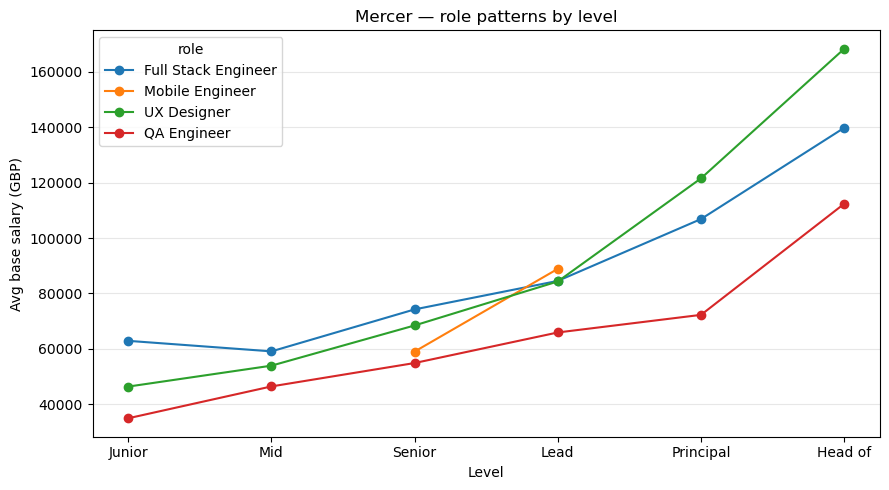

In [279]:
mercer_clean = pd.read_csv("data/processed/mercer_clean.csv")

plot_role_progression(mercer_clean, "Mercer — role patterns by level")